# 데이터 로드 

In [ ]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/commodity.zip

--2022-01-10 05:02:06--  https://github.com/dhrim/deep_learning_data/raw/master/commodity.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/commodity.zip [following]
--2022-01-10 05:02:07--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/commodity.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1835488 (1.8M) [application/zip]
Saving to: ‘commodity.zip’

commodity.zip       100%[===================>]   1.75M  --.-KB/s    in 0.07s   

2022-01-10 05:02:07 (25.4 MB/s) - ‘commodity.zip’ saved [1835488/1835488]



In [ ]:
!unzip commodity.zip

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
df = pd.read_csv('/content/commodity/Gold.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0
3,2000-09-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0


# 전처리 

## 결측값 확인 

In [ ]:
df.isnull().sum()

Date           0
Open         112
High         112
Low          112
Close        112
Adj Close    112
Volume       112
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 시간 순 정렬 확인 

In [ ]:
df = df.sort_values(by = ['Date'])

## 컬럼 제거 

In [ ]:
df = df.drop(columns = 'Date').drop(columns = 'Adj Close')

## Normalize 

In [ ]:
max = np.max(df,axis=0)
print(max)
print('\n')
min = np.min(df,axis=0)
print(min)

Open        2045.5
High        2063.0
Low         2040.0
Close       2051.5
Volume    386334.0
dtype: float64


Open      255.000000
High      256.100006
Low       255.000000
Close     255.100006
Volume      0.000000
dtype: float64


In [ ]:
normalized_df = (df-min)/(max-min)

데이터 확인 

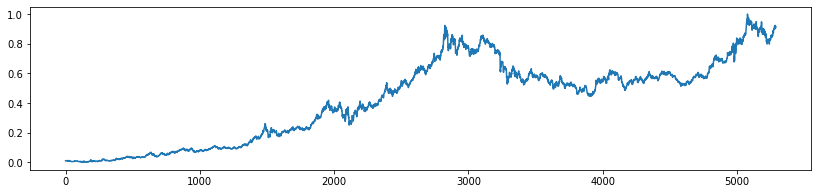

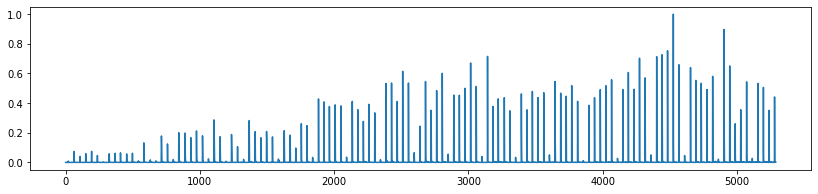

In [ ]:
#시계열 그래프 
plt.figure(figsize=(14,3))
plt.plot(normalized_df.iloc[:,0])
plt.show()

plt.figure(figsize=(14,3))
plt.plot(normalized_df.iloc[:,4])
plt.show()


Open


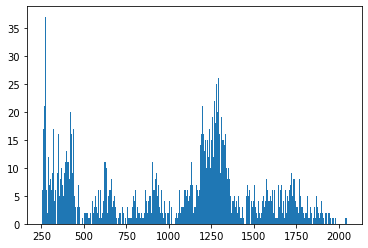

High


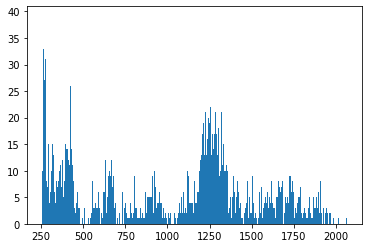

Low


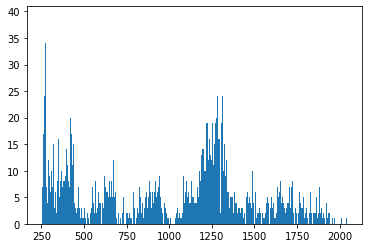

Close


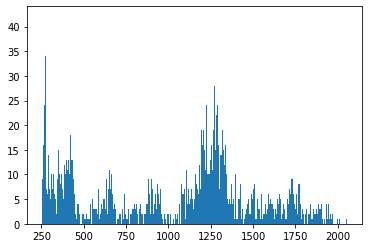

Volume


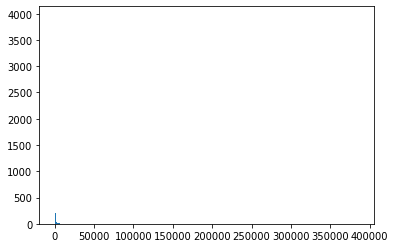

In [ ]:
for i in range(len(df.columns)):
    print(df.columns[i])
    plt.hist(df.iloc[:,i], bins=1000)
    plt.show()

# 데이터 분할 

## 파라미터 설정 

In [ ]:
SEQUENCE_LENGTH = 10
OFFSET = 1
BATCH_SIZE = 32

## 윈도우, 오프셋 생성 

In [ ]:
numbers = normalized_df.to_numpy()

In [ ]:
numbers.shape

(5179, 5)

pandas.core.frame.DataFrame

In [ ]:
raw_x = []
raw_y = []

for i in range(len(numbers)):
  if i+SEQUENCE_LENGTH+OFFSET >= len(numbers): break
  raw_x.append(numbers[i:i+SEQUENCE_LENGTH,:])
  raw_y.append(numbers[i+SEQUENCE_LENGTH+OFFSET-1,:])
#              0         1              
#              01234567890123456789
# numbers[0] = 12345678901234567890
#                 i = 3
#                 <-x->   = [3:8] = 45678
#                      y  = [8]   = 9



In [ ]:
raw_x = np.array(raw_x)
raw_y = np.array(raw_y)

In [ ]:
print(raw_x.shape,raw_y.shape)

(5168, 10, 5) (5168, 5)


In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=True)

# 모델링 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68608     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 69,953
Trainable params: 69,953
Non-trainable params: 0
_________________________________________________________________


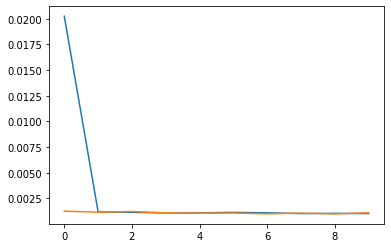

17/17 [==============================] - 0s 3ms/step - loss: 6.9059e-04 - mape: 171035.5625
loss= 0.0006905930931679904
mape= 171035.5625


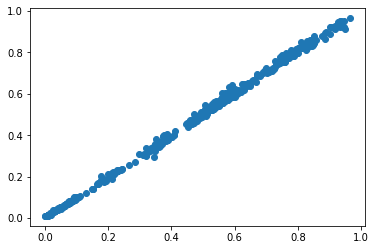

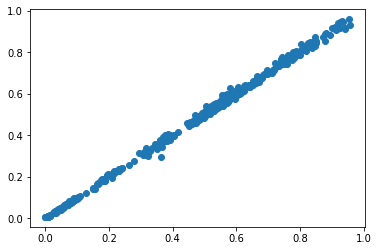

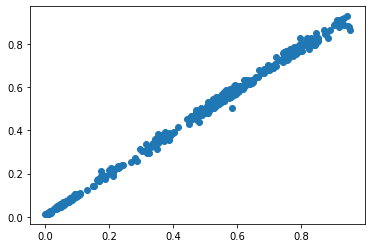

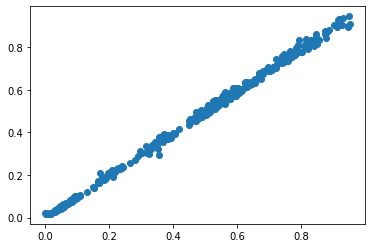

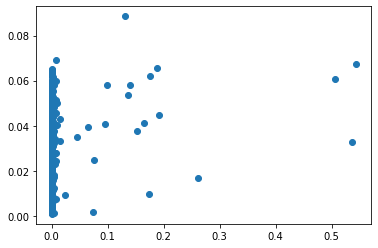

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
output_shape = train_y.shape[-1]

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(10, activation = 'relu')) #보통 flatten 다음에 hidden 한개 정도 넣어 줌 
model.add(Dense(output_shape))
model.compile(loss="mse", optimizer="adam", metrics=["mape"])
model.summary()

history = model.fit(train_x, train_y, epochs=10, verbose=0, validation_split=0.1, batch_size=BATCH_SIZE)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, mape = model.evaluate(test_x, test_y)
print("loss=", loss)
print("mape=", mape)



y_ = model.predict(test_x).squeeze()
for i in range(output_shape):
    plt.scatter(test_y[:,i], y_[:,i])
    plt.show()

# 삼성 주가 예측 

In [ ]:
df = pd.read_csv('/content/data_2824_20220110.csv',encoding = 'cp949')

In [ ]:
df.head()

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2022/01/10,77700,-600,-0.77,78100,78100,77100,7874219,611202385700,463852104135000,5969782550
1,2022/01/07,78300,1400,1.82,78100,78400,77400,15163757,1184236552700,467433973665000,5969782550
2,2022/01/06,76900,-500,-0.65,76700,77600,76600,12931954,996378432570,459076278095000,5969782550
3,2022/01/05,77400,-1300,-1.65,78800,79000,76400,25470640,1967841509800,462061169370000,5969782550
4,2022/01/04,78700,100,0.13,78800,79200,78300,12427416,977990613000,469821886685000,5969782550


## 필요없는 컬럼 제거 

In [ ]:
df.drop(columns = ['등락률','대비','시가총액','상장주식수'],inplace=True)

## 결측값 확인 

In [ ]:
df.isnull().sum()

일자      0
종가      0
시가      0
고가      0
저가      0
거래량     0
거래대금    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      744 non-null    object
 1   종가      744 non-null    int64 
 2   시가      744 non-null    int64 
 3   고가      744 non-null    int64 
 4   저가      744 non-null    int64 
 5   거래량     744 non-null    int64 
 6   거래대금    744 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 40.8+ KB


## 시간순 확인 

In [ ]:
df.head()

,일자,종가,시가,고가,저가,거래량,거래대금
0,2022/01/10,77700,78100,78100,77100,7874219,611202385700
1,2022/01/07,78300,78100,78400,77400,15163757,1184236552700
2,2022/01/06,76900,76700,77600,76600,12931954,996378432570
3,2022/01/05,77400,78800,79000,76400,25470640,1967841509800
4,2022/01/04,78700,78800,79200,78300,12427416,977990613000


In [ ]:
df = df.sort_values(by=['일자'])

## Normalized

In [ ]:
df.drop(columns = '일자',inplace=True)

In [ ]:
df.shape

(744, 6)

In [ ]:
max = np.max(df,axis=0)
print(max)
print('\n')
min = np.min(df,axis=0)
print(min)

종가              91000
시가              90300
고가              96800
저가              89500
거래량          90306177
거래대금    8379237727064
dtype: int64


종가             38100
시가             38000
고가             39200
저가             37950
거래량          4406531
거래대금    218263191350
dtype: int64


In [ ]:
normalized = (df-min)/(max-min)

## 데이터 분할 

In [ ]:
numbers = normalized.to_numpy()

In [ ]:
raw_x = []
raw_y = []

for i in range(len(numbers)):
  if i+SEQUENCE_LENGTH+OFFSET >= len(numbers): break
  raw_x.append(numbers[i:i+SEQUENCE_LENGTH,:])
  raw_y.append(numbers[i+SEQUENCE_LENGTH+OFFSET-1,:])
#              0         1              
#              01234567890123456789
# numbers[0] = 12345678901234567890
#                 i = 3
#                 <-x->   = [3:8] = 45678
#                      y  = [8]   = 9



In [ ]:
x = np.array(raw_x)
y = np.array(raw_y)
print(x.shape)
print(y.shape)

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, shuffle=True)

(733, 10, 6)
(733, 6)


## 모델

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               69120     
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dense_9 (Dense)             (None, 6)                 66        
                                                                 
Total params: 70,476
Trainable params: 70,476
Non-trainable params: 0
_________________________________________________________________


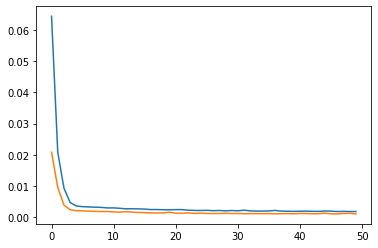

3/3 [==============================] - 0s 4ms/step - loss: 0.0016 - mape: 67763.6797
loss= 0.0015686159022152424
mape= 67763.6796875


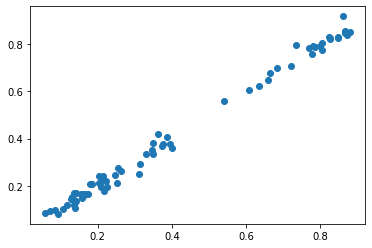

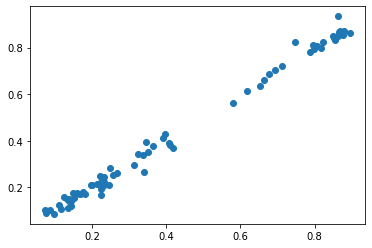

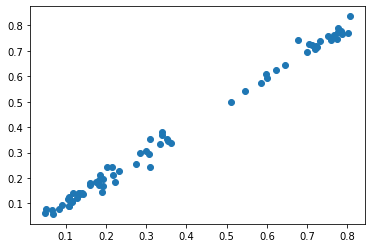

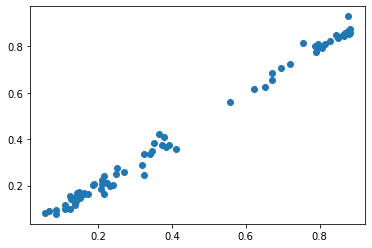

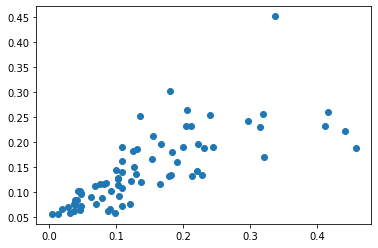

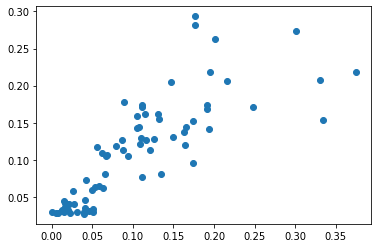

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
output_shape = train_y.shape[-1]

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(10, activation = 'relu')) #보통 flatten 다음에 hidden 한개 정도 넣어 줌 
model.add(Dense(output_shape))
model.compile(loss="mse", optimizer="adam", metrics=["mape"])
model.summary()

history = model.fit(train_x, train_y, epochs=50, verbose=0, validation_split=0.1, batch_size=BATCH_SIZE)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, mape = model.evaluate(test_x, test_y)
print("loss=", loss)
print("mape=", mape)



y_ = model.predict(test_x).squeeze()
for i in range(output_shape):
    plt.scatter(test_y[:,i], y_[:,i])
    plt.show()

In [ ]:
y_ = model.predict(test_x).squeeze()
for i in range(output_shape):
  plt.scatter(test_y[:,i], y_[:,i])
  plt.show()
  print('\n')

In [ ]:
y_.shape

(74, 6)

## 예측

In [ ]:
new_df = new_df.sort_values(by='일자', [o])

In [ ]:
new_df.head()

,일자,종가,시가,고가,저가,거래량,거래대금
743,2019/01/08,38100,38000,39200,37950,12756554,491578269750
742,2019/01/09,39600,38650,39600,38300,17452708,683003582870
741,2019/01/10,39800,40000,40150,39600,14731699,587063456542
740,2019/01/11,40500,40350,40550,39950,11661063,470286278900
739,2019/01/14,40050,40450,40700,39850,11984996,481959001650


In [ ]:
temp = new_df.iloc[-10:,1:]

In [ ]:
 temp = (temp - min)/(max-min)

In [ ]:
temp = np.array(temp).astype(float)

In [ ]:
temp= temp.reshape(1,10,6)

In [ ]:
predicted = model.predict(temp)

In [ ]:
predicted = predicted.reshape(6)

In [ ]:
tommorow = predicted *(max-min) + min

In [ ]:
tommorow = tommorow.astype(np.int)

In [ ]:
new_df.loc[745] = tommorow

In [ ]:
new_df

,일자,종가,시가,고가,저가,거래량,거래대금,index
743,2019/01/08,38100.0,38000.0,39200.0,37950.0,12756554.0,4.915783e+11,0
742,2019/01/09,39600.0,38650.0,39600.0,38300.0,17452708.0,6.830036e+11,1
741,2019/01/10,39800.0,40000.0,40150.0,39600.0,14731699.0,5.870635e+11,2
740,2019/01/11,40500.0,40350.0,40550.0,39950.0,11661063.0,4.702863e+11,3
739,2019/01/14,40050.0,40450.0,40700.0,39850.0,11984996.0,4.819590e+11,4
...,...,...,...,...,...,...,...,...
852,NaN,77234.0,77501.0,78203.0,76534.0,23546556.0,1.948587e+12,851
853,NaN,77236.0,77503.0,78205.0,76535.0,23546300.0,1.948610e+12,852
854,NaN,77238.0,77505.0,78206.0,76537.0,23546065.0,1.948635e+12,853
855,NaN,77239.0,77507.0,78208.0,76539.0,23545799.0,1.948654e+12,854


## 예측 한번에 

In [ ]:
new_df['index'] = np.arange(len(new_df))

In [ ]:
i = 0 
for i in range(1):
  temp = new_df.iloc[-10:,1:-1]
  temp = (temp - min)/(max-min)
  temp = np.array(temp).astype(float)
  temp= temp.reshape(1,10,6)
  predicted = model.predict(temp)
  predicted = predicted.reshape(6)
  tommorow = predicted *(max-min) + min
  tommorow = tommorow.astype(np.int)
  new_df.loc[len(new_df)+1] = tommorow
  new_df

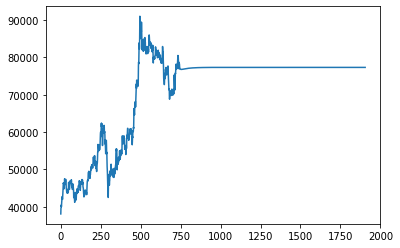

In [ ]:
plt.plot(new_df['index'],new_df['종가'])

# Bitcoin

In [ ]:
import pandas as pd 
import numpy as np 


In [ ]:
!unzip bitcoin.csv.zip

Archive:  bitcoin.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


In [ ]:
df = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [ ]:
df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

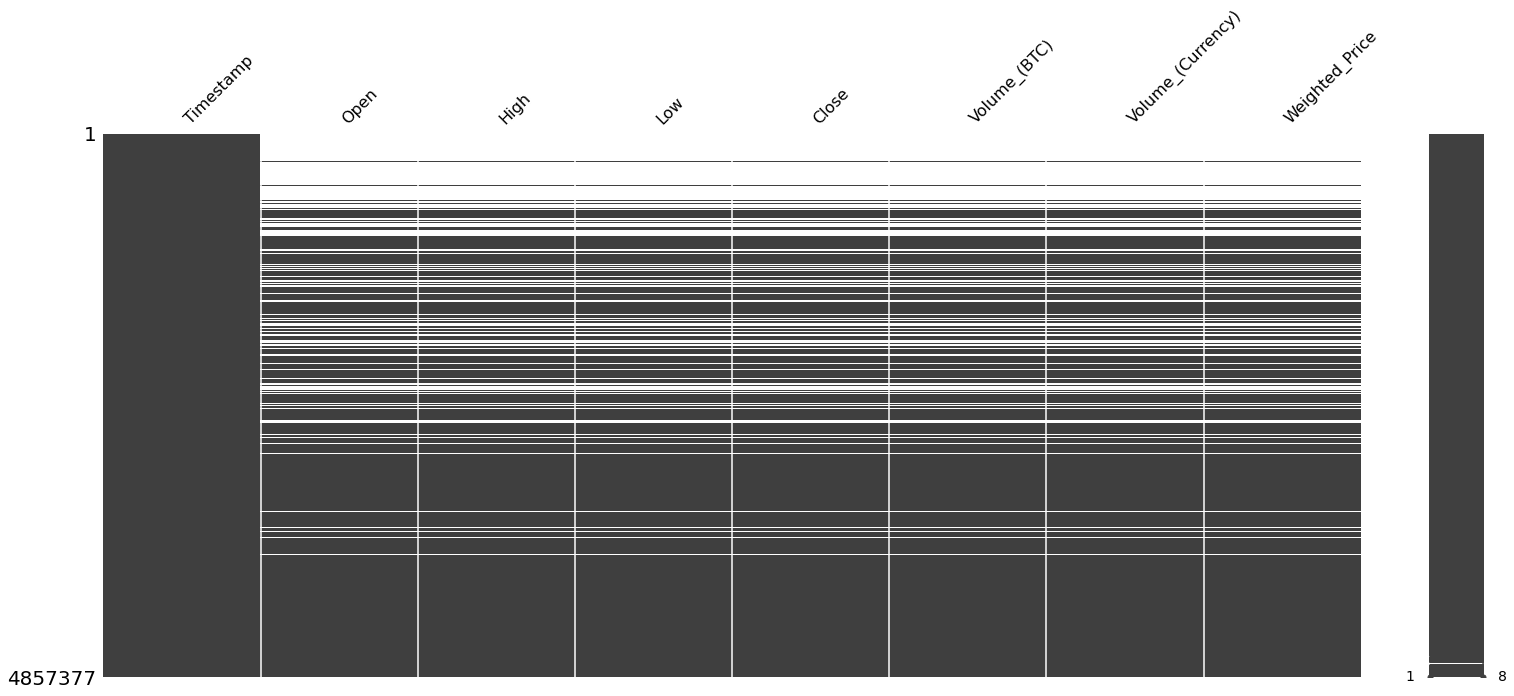

In [ ]:
import missingno as msno 
msno.matrix(df)

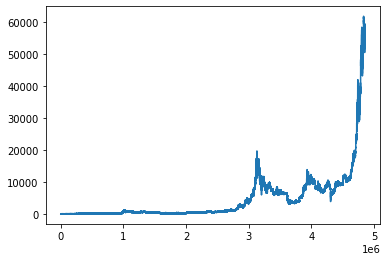

In [ ]:
plt.plot(np.arange(len(df)),df['Open'])

In [ ]:
timestamp = df['Timestamp']

In [ ]:
temp = timestamp[0]

In [ ]:
temp = str(temp)

In [ ]:
import datetime
date = []
for temp in timestamp:
  _date = datetime.datetime.fromtimestamp(int(temp)).strftime('%Y-%m-%d %H:%M:%S')
  date.append(_date)

In [ ]:
date[0][:13]

'2011-12-31 07'

In [ ]:
date = np.array(date)

In [ ]:
for i in range(len(date)):
  date[i] = date[i][:13]

In [ ]:
df['Date'] = date

In [ ]:
df = df.drop(columns = ['Volume_(BTC)','Volume_(Currency)','Weighted_Price'])

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close
0,1325317920,4.39,4.39,4.39,4.39
1,1325317980,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN


In [ ]:
df = df.fillna(method = 'bfill')

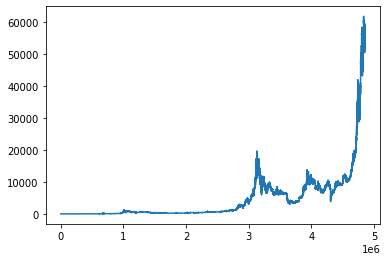

In [ ]:
plt.plot(np.arange(len(df)),df['Open'])

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close
0,1325317920,4.39,4.39,4.39,4.39
1,1325317980,4.39,4.39,4.39,4.39
2,1325318040,4.39,4.39,4.39,4.39
3,1325318100,4.39,4.39,4.39,4.39
4,1325318160,4.39,4.39,4.39,4.39


In [ ]:
df = df.sort_values(by='Timestamp')

In [ ]:
index = len(df)

In [ ]:
index

4857377

In [ ]:
pre_df = df.iloc[int(index*0.9):,:]

In [ ]:
pre_df = pre_df.drop(columns = 'Timestamp')

In [ ]:
min = np.min(pre_df)
max = np.max(pre_df)

In [ ]:
pre_df = (pre_df-min)/(max-min)

In [ ]:
numbers = pre_df.to_numpy()

In [ ]:
SEQUENCE_LENGTH = 10
OFFSET = 1
BATCH_SIZE = 32

In [ ]:
raw_x = []
raw_y = []

for i in range(len(numbers)):
  if i+SEQUENCE_LENGTH+OFFSET >= len(numbers): break
  raw_x.append(numbers[i:i+SEQUENCE_LENGTH,:])
  raw_y.append(numbers[i+SEQUENCE_LENGTH+OFFSET-1,:])
#              0         1              
#              01234567890123456789
# numbers[0] = 12345678901234567890
#                 i = 3
#                 <-x->   = [3:8] = 45678
#                      y  = [8]   = 9



In [ ]:
x = np.array(raw_x)
y = np.array(raw_y)
print(x.shape)
print(y.shape)

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, shuffle=True)

(485727, 10, 4)
(485727, 4)


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
output_shape = train_y.shape[-1]

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(10, activation = 'relu')) #보통 flatten 다음에 hidden 한개 정도 넣어 줌 
model.add(Dense(output_shape))
model.compile(loss="mse", optimizer="adam", metrics=["mape"])
model.summary()

history = model.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.1, batch_size=BATCH_SIZE)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 69,430
Trainable params: 69,430
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12295/12295 [==============================] - 53s 4ms/step - loss: 7.2771e-05 - mape: 9.7851 - val_loss: 1.4123e-06 - val_mape: 0.9508
Epoch 2/10
12295/12295 [=============

NameError: ignored

# 예측 

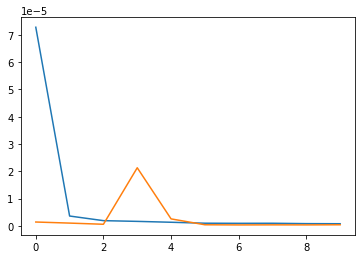

1518/1518 [==============================] - 4s 3ms/step - loss: 4.1441e-07 - mape: 0.4150
loss= 4.1440668496761646e-07
mape= 0.41504111886024475


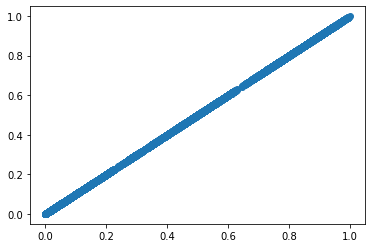

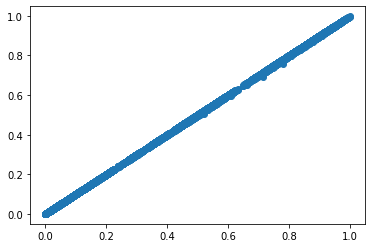

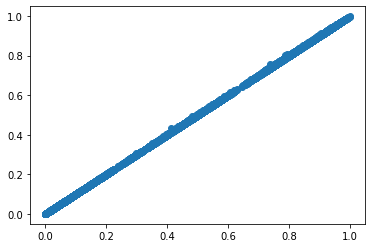

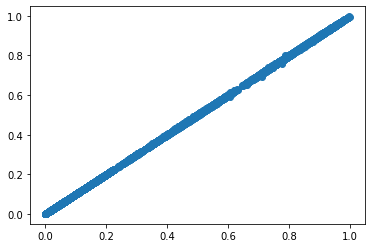

In [ ]:
import matplotlib.pyplot as plt 


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, mape = model.evaluate(test_x, test_y)
print("loss=", loss)
print("mape=", mape)



y_ = model.predict(test_x).squeeze() 
for i in range(output_shape):
    plt.scatter(test_y[:,i], y_[:,i])
    plt.show()

In [ ]:
y_.shape

(48573, 4)

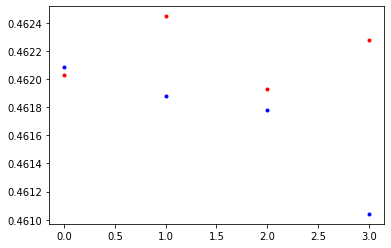

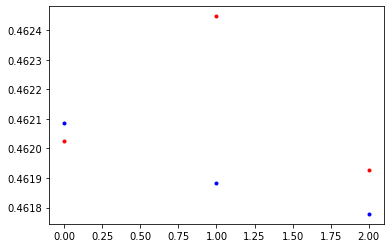

In [ ]:
plt.plot(test_y[0], 'b.')
plt.plot(y_[0], 'r.')
plt.show()

plt.plot(test_y[0,:-1], 'b.')
plt.plot(y_[0,:-1], 'r.')
plt.show()

In [ ]:
maxs = np.array(max)
mins = np.array(min)

In [ ]:
denomalized_test_y = test_y * (maxs - mins) + mins
denomalized_y_ = y_ * (maxs - mins) + mins
delogged_test_y = np.exp(denomalized_test_y) - 1
delogged_y = np.exp(denomalized_y_) - 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


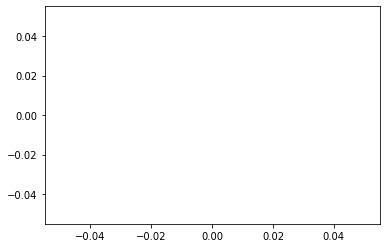

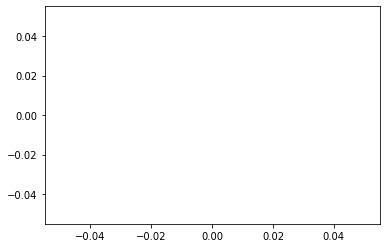

In [ ]:
plt.plot(delogged_test_y[0], 'bo')
plt.plot(delogged_y[0], 'r.')
plt.show()

plt.plot(delogged_test_y[0,:-1], 'bo')
plt.plot(delogged_y[0,:-1], 'r.')
plt.show()